# 猫狗大战（Dogs v.s. Cats）
## 项目：使用Keras神经网络API，实现一个可以区分猫，狗的算法APP
### Keras简介（引自Keras API 官方文档：https://keras-zh.readthedocs.io ）
Keras 是一个用 Python 编写的高级神经网络 API，它能够以 TensorFlow, CNTK 或者 Theano 作为后端运行。Keras 的开发重点是支持快速的实验。能够以最小的时延把你的想法转换为实验结果，是做好研究的关键。

Keras 在以下情况下更适用:

1、允许简单而快速的原型设计（由于用户友好，高度模块化，可扩展性）。

2、同时支持卷积神经网络和循环神经网络，以及两者的组合。

3、在 CPU 和 GPU 上无缝运行。

Keras 兼容的 Python 版本: Python 2.7-3.6。

PS：本项目适用的python版本是3.7.3,但是对Keras的支持仍然非常好。

---

### 项目简介：

猫咪和狗狗是人们日常生活中最常见的宠物，通过它们的个头儿，毛发，长相等显而易见的特征，人们很容易将他们彼此区分开来，但是对于计算机来说，区分猫和狗并不那么容易。

本项目的最终目标是通过使用神经网络框架，设计一个算法，通过大量的图片对算法进行训练，将训练所得的参数应用于我所设计的算法，从而让计算机可以以较高的准确率来区别一张图片中是猫咪还是狗狗，或者两者都不是。

---
### 模型评价指标
项目中模型使用Logarithmic loss 即：log loss来评价模型，与准确率相比，log loss会根据预测结果与实际标签的差异，考虑模型预测的不确定性，让我们对模型的性能有更细致的了解。

计算公式为：
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]，其中:y_i为真实值，\hat{y}_i为预测值$$

下图是真实的Label=1时的log loss曲线图。
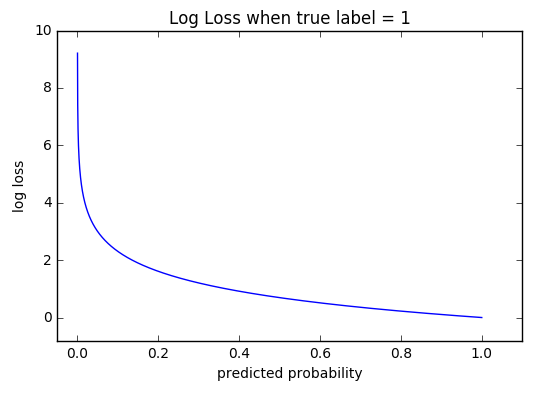

## 准备工作
在项目开始之前，需要以下准备工作：

1、检查python版本，保证使用python3.x版本来完成项目。

2、将需要用的文件（训练数据，测试数据）名称加载至内存，重新洗牌并生成分类标签。

In [1]:
# 检查Python版本
from sys import version_info
if version_info.major != 3:
    raise Exception('请使用Python 3.x 来完成此项目')

In [3]:
from glob import glob
import numpy as np
import random

# 准备数据
# 加载训练集数据并重新洗牌
random.seed(8769530)
train_tobe_load = np.array(glob("data/train/*"))
random.shuffle(train_tobe_load)

# 提取文件名称
image_names = [name[name.rfind('/')+1:] for name in train_tobe_load]

# 加载测试文件名
test_files = np.array(glob("data/test/*"))
print("There are %d images to be trained." % len(train_tobe_load))
print("There are %d test images." % len(test_files))

There are 25000 images to be trained.
There are 12500 test images.


## 探索数据
影响图像分类的因素有很多，比如图像的大小，图像的清晰度，图像的亮度，图像中是否存在分类种类以外的对象，是否存在严重遮挡等。下面就行这几方面对数据进行并可视化一些特征。并根据在之后所使用的训练数据的要求对原始数据进行必要的处理。

In [4]:
from PIL import Image
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
%matplotlib inline

# 随机选取图像进行显示
def random_show(dataset, title):
    indices = [random.randint(1,len(dataset)) for _ in range(8)]
    plt.figure(figsize=(15,5))
    plt.suptitle(title)
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.title(dataset[indices[i]])
        plt.imshow(Image.open(dataset[indices[i]]))
        plt.axis('off')
    plt.show

# 获取图像尺寸，计算图像清晰度
def get_image_info(imgname):
    img = cv2.imread(imgname,cv2.IMREAD_GRAYSCALE)
    #将图像大小归一化到(224,224)
    newImg = cv2.resize(img, (224,224))
    imageVar = cv2.Laplacian(newImg, cv2.CV_64F).var()
    return [img.shape[0],img.shape[1],round(imageVar,2)]

In [4]:
images_info = np.array([get_image_info(img) for img in tqdm(train_tobe_load)])

100%|██████████| 25000/25000 [01:21<00:00, 308.40it/s]


## 探索数据
#### 观察数据
在训练集随机选取8张图片进行显示并观察图片特征。

可以发现，随机选出的图片具有以下特征：

1、图片分辨率低，比如dog.4412.jpg.
2、有的图像中的分类对象（猫、狗）在图像中的比例偏小，如dog.4412.jpg。
3、有些图像的对比度不高，即不够清晰，图像中的前景和背景不容易区分，如cat.11539.jpg。
通过观察可以发现这些问题，这都对后续的算法训练分类构成了很大的挑战。

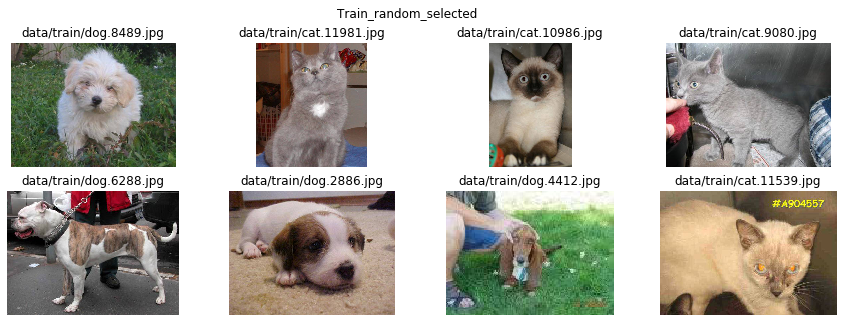

In [5]:
random_show(train_tobe_load, 'Train_random_selected')

## 探索数据
#### 可视化图像尺寸分布
通过观察图像尺寸的散点图，发现异常数据，以下可视化图中，横轴代表图像宽度，纵轴代表图像高度，图中的一个点完整了表示了一张图像的宽高信息。

通过可视化图表，可以发现有两张图像的大小要远大于其他图像，而且有一部分图像的尺寸则比较小，width<80并且height<80。

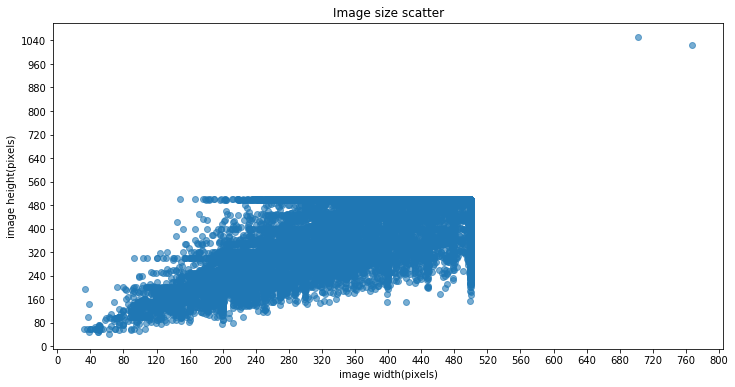

In [6]:
# 可视化图像大小分布
plt.figure(figsize=(12,6))
plt.title("Image size scatter")
plt.xlabel("image width(pixels)")
plt.ylabel("image height(pixels)")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_major_locator(MultipleLocator(80))
plt.scatter(images_info[:,0], images_info[:,1], alpha=0.6)
plt.show()

## 探索数据
#### 可视化图像清晰度数据
严格意义上来说，图像的清晰度是一个主观概念，没有绝对的客观衡量标准。最常见的是数字信号处理中，对图像做傅立叶变换，然后观察图像的高低频特征分布。如果图片有少量的高频成分，那么该图片就可以被认为是模糊的。然而，区分高频量多少的具体阈值却是十分困难的，不恰当的阈值将会导致极差的结果。

这里，我们的期望是可以使用一个单一的数值来直观表示图像的清晰度度量。Pech-Pacheco 在 2000 年模式识别国际会议提出将图片中某一通道（一般用灰度值）通过拉普拉斯（Laplacian）掩模做卷积运算，然后计算标准差，出来的值就可以代表图片清晰度。这种方法的之所以有效在于拉普拉斯算子是用于测量图像的二阶导数，突出图片中快速变化的区域。此算法基于以下假设：如果图片具有较高方差，那么它就有较广的频响范围，代表着正常，聚焦准确的图片。但是如果图片具有有较小方差，那么它就有较窄的频响范围，意味着图片中的边缘数量很少。正如我们所知道的，图片越模糊，其边缘就越少。

但是在下面的探索中可以看到，一些分辨率，具有大量马赛克状的图像也很会有比较高的Laplacian卷积值，但是它们绝对是模糊的图像，同时，一些背景模糊但是前景清晰的图像也会由于其较低的Laplacian值被错杀。

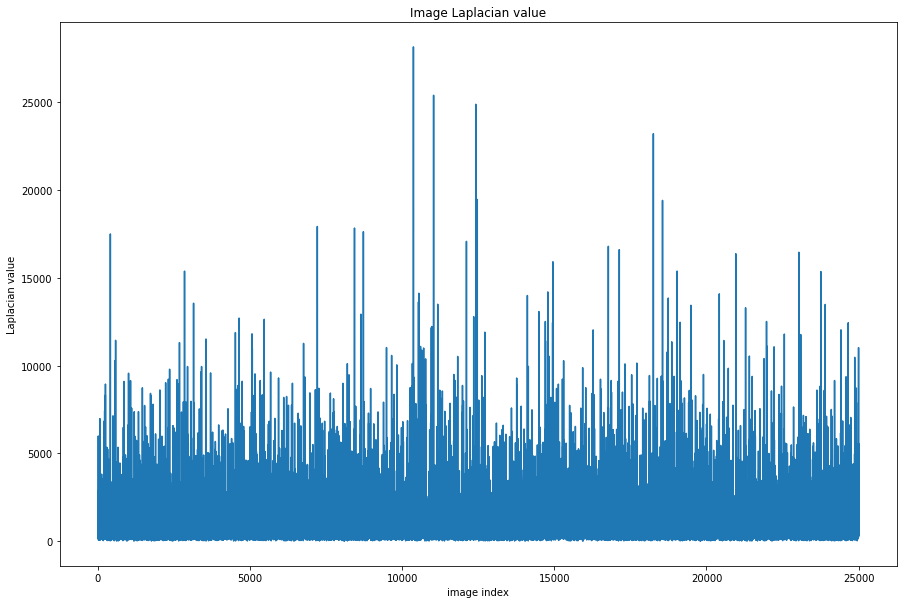

Max Lap-value is: 28154.3200, Min Lap-value is: 4.9900


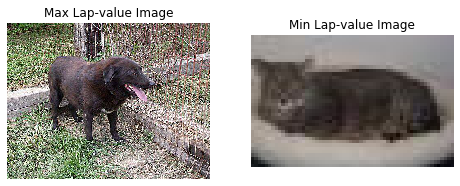

In [7]:
# 绘制清晰度曲线
plt.figure(figsize=(15,10))
plt.title("Image Laplacian value")
plt.xlabel("image index")
plt.ylabel("Laplacian value")
plt.plot(np.arange(len(train_tobe_load)), images_info[:,2])
plt.show()
print('Max Lap-value is: %.4f, Min Lap-value is: %.4f' % (np.max(images_info[:,2]), np.min(images_info[:,2])))

plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.title('Max Lap-value Image')
plt.imshow(Image.open(train_tobe_load[np.argmax(images_info[:,2])]))
plt.axis('off')
           
plt.subplot(1,2,2)
plt.title('Min Lap-value Image')
plt.imshow(Image.open(train_tobe_load[np.argmin(images_info[:,2])]))
plt.axis('off')
plt.show()

## 探索数据
#### 查找异常数据
上面完成了对图像尺寸和清晰度(Lap-value)的可视化统计，通过可视化图表即输出信息可以知道，数据集中有尺寸很小的图片，也有两张很大的图片，有清晰度很高的图片，也有非常模糊的图片。而图像的尺寸往往与图像清晰度有直接关系，一个常识是，图像的尺寸越小，清晰度也越低。

对于本项目的猫狗分类任务，这可能都不是最重要的异常数据。最终的异常是图像中是否包含猫、狗对象。

在这一步，我将使用Keras库中的预训练模型对训练集数据进行分类，与ImageNet中生成的猫狗分类数据进行比较，将不包含于ImageNet分类结果中的数据找出，然后手工进行进一步筛选。

___

在Keras库中，可以发现如下描述：

<table>
    <tr>
        <td ><center>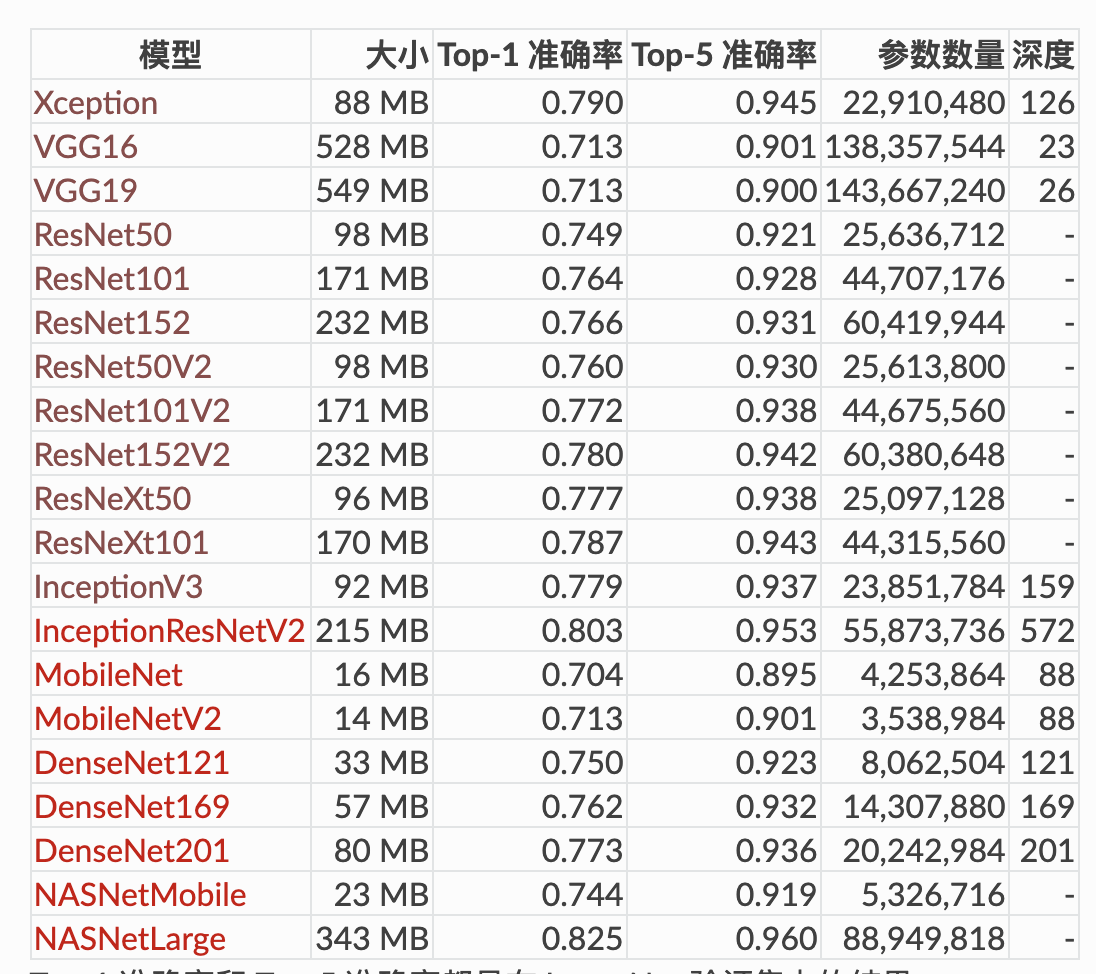模型准确率描述</center></td>
    </tr>
</table>

可以发现，预训练模型，如ResNet50的top-5 > top-1。top-1是指一张狗的图片，模型判断它是狗的概率最高，即最大概率是狗的准确率。top-5是指，模型给出5个可能分类，5个概率中包含正确分类的准确率。由top-5 > top-1可以简单推断，top-N > top-(N-1)，这给我们确定使用那个层级的准确率提供的思路。下面对不同的top-N进行探索。

In [3]:
from keras.applications import *
from keras.preprocessing import image

detect_model = resnet50.ResNet50('imagenet')
img = image.load_img(train_tobe_load[0], target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = resnet50.preprocess_input(x)

preds = detect_model.predict(x)

Using TensorFlow backend.


In [9]:
print("Top-1: ",resnet50.decode_predictions(preds, top=1)[0])
print("Top-3: ",resnet50.decode_predictions(preds, top=3)[0])
print("Top-5: ",resnet50.decode_predictions(preds, top=5)[0])
print("Top-10: ",resnet50.decode_predictions(preds, top=10)[0])
print("Top-15: ",resnet50.decode_predictions(preds, top=15)[0])

Top-1:  [('n02123045', 'tabby', 0.40851644)]
Top-3:  [('n02123045', 'tabby', 0.40851644), ('n02124075', 'Egyptian_cat', 0.24493799), ('n02123159', 'tiger_cat', 0.14829175)]
Top-5:  [('n02123045', 'tabby', 0.40851644), ('n02124075', 'Egyptian_cat', 0.24493799), ('n02123159', 'tiger_cat', 0.14829175), ('n02127052', 'lynx', 0.09430619), ('n02123597', 'Siamese_cat', 0.004690375)]
Top-10:  [('n02123045', 'tabby', 0.40851644), ('n02124075', 'Egyptian_cat', 0.24493799), ('n02123159', 'tiger_cat', 0.14829175), ('n02127052', 'lynx', 0.09430619), ('n02123597', 'Siamese_cat', 0.004690375), ('n03958227', 'plastic_bag', 0.004041627), ('n02123394', 'Persian_cat', 0.0040392014), ('n04589890', 'window_screen', 0.0032428638), ('n02120505', 'grey_fox', 0.00282969), ('n02971356', 'carton', 0.0027673822)]
Top-15:  [('n02123045', 'tabby', 0.40851644), ('n02124075', 'Egyptian_cat', 0.24493799), ('n02123159', 'tiger_cat', 0.14829175), ('n02127052', 'lynx', 0.09430619), ('n02123597', 'Siamese_cat', 0.00469037

分析上面的结果，可以发现，当使用模型的top-10时，从模型给出的第六类开始，属于某一类的概率已经降低到了1%以下，说明属于某一类的概率已经很低。
为了尽可能的对数据进行自动清理，同时又要保证效率，这里我使用二段检测方法。

1、使用top-10准确率，对数据进行初步筛选。为了尽可能查找出数据，这一步将使用VGG19,ResNet50两个模型对全训练集进行分类，并将分类结果合并保存。

2、使用top-30准确率，对第一步中产生的数据集进行进一步分类。这一步将加入Xception模型，使用三个模型对上一步中产生的疑似数据进行分类。

## 探索数据
#### 确定数据标准
通过上面的可视化图，可以看出，在尺寸小于 $80\times80$ 的图像中，图像的Lap-value最高的为98.59，最低是4.99，前一张可以看出是一只猫的图片，后一张，可能除了从文件名中可以知道这是一只猫，从图像本身，真的不能确定它是一只什么动物。

对于图像清晰度评判标准，有理由认为，当图像的Lap-value<100时，图像为模糊的，那么对于整体数据的预处理，通过以下步骤进行：

1、清洗图像尺寸过大的图片。通过上面的分析可以看出，数据集中有两张图像的尺寸大于$650\times1000$

2、清洗模糊的图像。通过上面对小尺寸图像清晰度的探索，以最后得出的Lap-value=100为标准，低于这个值的图像将被清洗。

---

## 预处理
### 数据清洗
下面的代码单元将按照上面的两个步骤对数据进行清洗。

下面的代码单元是ImageNet中，对猫、狗品种的分类集合，共有狗118个品种，猫7个品种。

In [5]:
dogs = [
 'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cats=['n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

dog_cats = set(dogs) | set(cats)

#### 使用VGG19   ResNet50的top-10准确率，对数据进行初步筛选

In [6]:
# 实现分类函数
def res_prdict(model, imagename, img_size,top_n):
    img = image.load_img(imagename, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet50.preprocess_input(x)
    
    preds = model.predict(x)
    results = [unit[0] for unit in resnet50.decode_predictions(preds, top=top_n)[0]]
    if (len(set(results) & dog_cats) > 0):
        return None
    else:
        return imagename

def vgg_predict(model, imagename, img_size,top_n):
    img = image.load_img(imagename, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = vgg19.preprocess_input(x)

    preds = model.predict(x)
    results = [unit[0] for unit in vgg19.decode_predictions(preds, top=top_n)[0]]
    if (len(set(results) & dog_cats) > 0):
        return None
    else:
        return imagename
    
def find_images(data):
    vgg19_model = vgg19.VGG19(weights='imagenet')
    resnet_model = resnet50.ResNet50(weights='imagenet')
    vgg_files = [vgg_predict(vgg19_model, image, (224,224), 10) for image in tqdm(data)]
    res_files = [res_prdict(resnet_model, image, (224,224), 10) for image in tqdm(data)]
    
    return list(set(res_files) | set(vgg_files))

In [6]:
files_1 = find_images(train_tobe_load[:10001])

100%|██████████| 10001/10001 [05:31<00:00, 30.17it/s]


In [7]:
files_2 = find_images(train_tobe_load[10001:20001])

100%|██████████| 10000/10000 [05:27<00:00, 30.54it/s]


In [8]:
files_3 = find_images(train_tobe_load[20001:])

100%|██████████| 4999/4999 [02:42<00:00, 30.73it/s]


In [9]:
filtered_files = np.array(list(set(files_1) | set(files_2) | set(files_3)))
print('There are %d strange images' % len(filtered_files))

There are 491 strange images


In [14]:
np.save("./saved_models/filtered_files.npy", filtered_files)

#### 加入Xception模型，使用top-30进行第二次筛选
上一步中，一共产生了491张的疑似图片，这里进一步筛选。

In [7]:
def x_predict(model, imagename, img_size,top_n):
    img = image.load_img(imagename, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = xception.preprocess_input(x)

    preds = model.predict(x)
    results = [unit[0] for unit in xception.decode_predictions(preds, top=top_n)[0]]
    if (len(set(results) & dog_cats) == 0):
        return imagename
    
    
def further_classify(data):
    vgg19_model = vgg19.VGG19(weights='imagenet')
    resnet_model = resnet50.ResNet50(weights='imagenet')
    xception_model = xception.Xception(weights='imagenet')
    vgg_files = [vgg_predict(vgg19_model, image, (224,224), 30) for image in tqdm(data)]
    res_files = [res_prdict(resnet_model, image, (224,224), 30) for image in tqdm(data)]
    x_files = [x_predict(xception_model, image, (299,299), 30) for image in tqdm(data)]
    
    return list(set(res_files) | set(vgg_files) | set(x_files))

In [8]:
saved_data = np.load("./saved_models/filtered_files.npy",allow_pickle=True)
firststep_data = [value for value in saved_data if value != None]
print("%d images loaded" % len(firststep_data))

490 images loaded


In [9]:
strange_data = further_classify(firststep_data)
print("Totally %d strange images dectected in further classification" % len(strange_data))

100%|██████████| 490/490 [00:22<00:00, 21.86it/s]

Totally 146 strange images dectected in further classification


Totally 145 strange images dectected in further classification


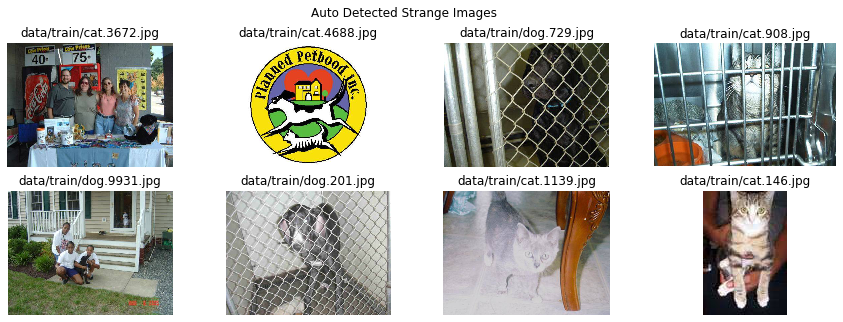

In [12]:
strange_data = [data for data in strange_data if data != None]
print("Totally %d strange images dectected in further classification" % len(strange_data))
random_show(strange_data, 'Auto Detected Strange Images')

可以看到，经过第二次分类后，从第一步的490张异常图片降低到了145张，但是通过上面的随机抽查可以发现图片中仍旧存在被错杀的图片，下面将这145张图片拷贝出来，进行人工筛选。

In [13]:
import shutil

for filename in strange_data:
    shutil.copy(filename, 'filtered_files/'+filename[filename.rfind('/')+1 :])

人工从中选出了82张图片，作为最终需要清理的图片。

Finally, there are total 82 strange images to be cleaned


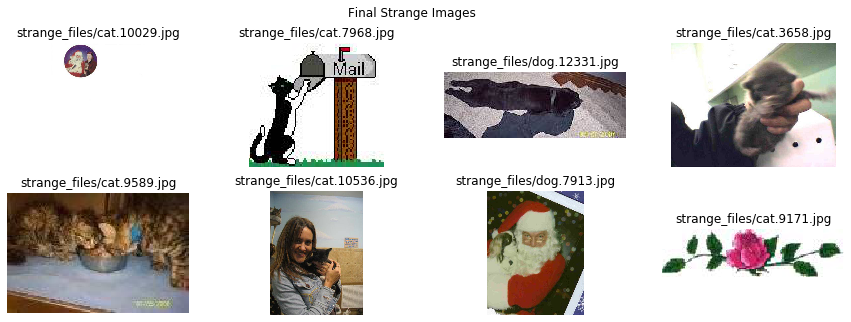

In [4]:
final_stranges = np.array(glob("strange_files/*"))
print("Finally, there are total %d strange images to be cleaned" % len(final_stranges))
random_show(final_stranges, 'Final Strange Images')

In [5]:
strange_data_names = [name[name.rfind('/')+1:] for name in final_stranges]

In [6]:
cleaned_triandata = list(set(image_names) - set(strange_data_names))
print("There are %d images after cleaned." % len(cleaned_triandata))

There are 24918 images after cleaned.


## 预处理
### 数据增强
前面讨论了图像清晰度的一个判断指标:Laplacian value，它的一个假设是一张图像的方差越大，说明它具有更大的频响范围。这就是说，在它的频响范围内可以呈现的细节越多。在众多的图像增强算法中，最常用的是调整图像的直方图，通过对原有直方图的拉伸，扩大图像像素值的分布区间，从而达到使图像更清晰，能呈现更多细节的目的。一个常用的方法是直方图均衡化。

如下图，是一张图片直方图均衡化前后的直方图和效果图：

<table>
    <tr>
        <td ><center>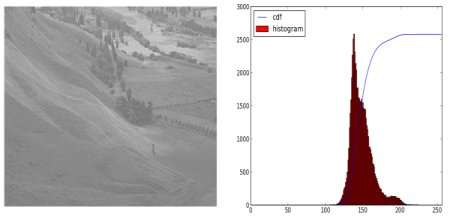图1 原图-直方图</center></td>
        <td ><center>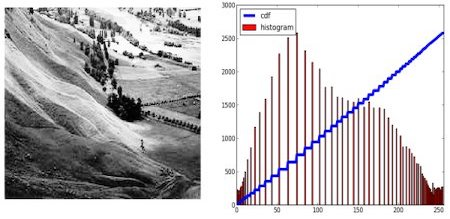图2 直方图均衡化效果-直方图</center></td>
    </tr>
</table>

可以看出，直方图均衡化后，图像能够呈现更多细节，更清晰。

下面的代码单元使用CLAHE (Contrast Limited Adaptive Histogram Equalization)算法对图像进行直方图均衡化处理。

以上资料引自：https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html

In [7]:
# 使用CLAHE算法对彩色图像增强
def image_enhance(file):
    img = cv2.imread(file)   
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(2,2))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return rgb

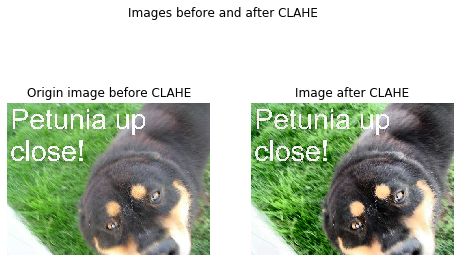

In [8]:
# 显示原图和增强后的图
imgname = 'data/train/' + cleaned_triandata[0]

plt.figure(figsize=(8,5))
plt.suptitle("Images before and after CLAHE")
plt.subplot(1,2,1)
plt.title("Origin image before CLAHE")
plt.imshow(Image.open(imgname))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Image after CLAHE")
plt.imshow(image_enhance(imgname))
plt.axis('off')
plt.show()


可以明显看出，使用CLAHE增强后的图像，明显比原图有更高的对比度，图中动物的细节更明显。有理由猜测这回对之后将要训练的模型表现有很大提升。

尽管在使用图像直方图均衡化算法增强图像时，并不是对所有图像都适用，但是上面的测试中，对具有最大Lap-value的图像，增强效果也很明显，说明在本项目使用的数据集中，可以对所有的图像使用该增强算法。

---
### 增强后的特征值
使用下面的代码单元观察数据增强后的Lap-value。可以看到，均衡化直方图后，数据集的最小值由原来的100.06增大到了现在的113.03.

In [9]:
def enhance_info(image):
    img = cv2.cvtColor(image_enhance(image), cv2.COLOR_RGB2GRAY)
    newImg = cv2.resize(img, (224,224))
    imageVar = cv2.Laplacian(newImg, cv2.CV_64F).var()
    return imageVar    

In [10]:
enhanced_Laps = [enhance_info('data/train/'+img) for img in tqdm(cleaned_triandata)]

100%|██████████| 24918/24918 [03:21<00:00, 123.81it/s]


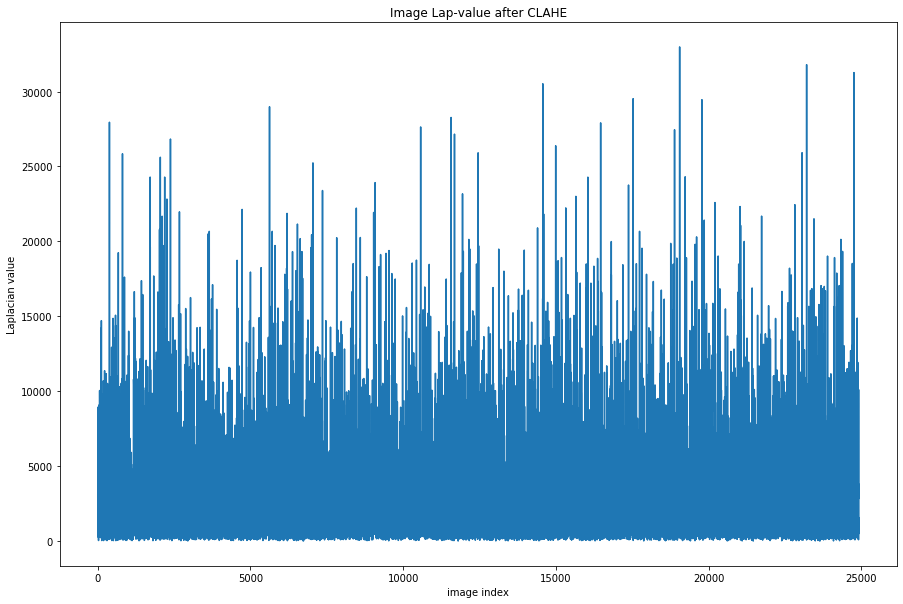

After enhanced, Min-Lap is:8.8134, Max-Lap is:32974.9543.


In [12]:
# 绘制增强后的清晰度曲线
plt.figure(figsize=(15,10))
plt.title("Image Lap-value after CLAHE")
plt.xlabel("image index")
plt.ylabel("Laplacian value")
plt.plot(np.arange(len(cleaned_triandata)), enhanced_Laps)
plt.show()

print("After enhanced, Min-Lap is:%.4f, Max-Lap is:%.4f." % (np.min(enhanced_Laps),np.max(enhanced_Laps)))

## 开始项目
从神经网络理论的提出，不断完善知道现如今取得巨大的发展，期间出现了众多适合图像识别、图像分类、图像分割的算法，在卷积神经网络（Converlutional Neural Network）理论提出后，更是涌现了众多表现优秀的模型。其中经典的代表模型有LeNet,VGG,GoogLeNet,AlexNet,ResNet等。它们在ImageNet数据集上的表现非常优秀。

本项目使用的神经网络库——Keras中，已经集成了包括以上经典模型在内的众多模型，在下面的讨论中，将进一步讨论项目中用到的算法和配合算法使用的数据处理，模型优化技术等。

---
### 迁移学习
__迁移学习__ 是一个使用已经训练好的模型来解决相似任务的过程。这个已经训练好的模型被称为预训练模型。相似任务是指当前任务与已经训练好的模型具有类似的任务目标，比如识别，分类等，并且数据集有一定的相似性，如训练集都是包含花、草、猫、狗、人等对象的图像，而不是使用在图像集上训练的模型进行自然语言的处理。在迁移学习过程中，可以将预训练模型的一个或多个层应用于新模型中来解决当前的新任务。

上面介绍中提到的VGG，ResNet等经典预训练模型，都可以作为迁移学习的基本模型使用。使用这些经典模型作为新问题模型的基础模型，有很多好处。如：

1、学到的有用特征：这些模型已经从ImageNet提供的含有1,000,000 张图像的数据集中学习了如何从图像中检测数据的通用特征。

2、最前沿的技术：这些模型在设计解决相应问题时，都使用了当前最前沿的技术，并且在它们各自的图像识别领域有很好的表现。

3、容易获取：这些模型都已经包含在本项目使用的Keras神经网络库中，并且它们预训练的权重可以很容易的通过网络下载。

最后，最重要的一点，使用迁移学习可以大大降低模型的训练时间，并且可以有效的控制在泛化数据上的误差。

### 如何使用预训练模型
预训练模型就像一个工具的集合，使用起来非常灵活。比如可以将模型照搬直接集成到具有图像识别、分类功能的App中，也可以将预训练模型作为特征提取的模型使用，这时候，预训练模型顶层以下层的输出将作为新的分类模型的输入。

总的来说，预训练模型的使用方法主要有以下几种：

1、直接作为分类器使用：直接将预训练模型及其参数作为分类器执行图像图像分类任务。

2、作为独立的特征提取工具使用：使用模型或模型的一部用来执行图像的预处理和相关的特征提取任务。通过调用模型中不同的网络层来提取不同的特征，越靠近输入层（底层）的网络层，提取的特征越基础，比如直线、点等特征，越靠近输出层（顶层）的神经层提取的特征越复杂。通过调用这些层，可以将它们的输出保存，作为后续处理的输入使用。

3、作为集成的特征提取器使用：将模型或模型的一部分集成到新的模型中使用。此时，集成到新模型中的预训练模型层的权重会被冻结，在新模型的训练过程中这些参数不会被更新。

4、权重初始化：将模型或模型的一部分集成到新的模型中使用，并在训练过程中作为新模型的一部分，调整之前训练过的权重。

上面四种使用预训练模型的方法，没有优劣高下之分，不管使用哪种方法，往往都要根据不同的任务进行模型的调优并经过多次实验才能得到理想的效果.

---
## 算法
在Keras包含的众多模型中，几乎每个模型都包含庞大的参数，使用ImageNet数据集进行训练时，往往需要使用高性能的硬件经过数天或者数十天的训练才能完成。在本项目环境下，显然不具备这样的硬件条件，而且时间上也来不及。基于这些客观条件的限制，最好的办法是使用迁移学习来完成项目。

所以，本项目使用的算法是基于__迁移学习__。

### 选择模型
每个模型在设计的时候都和具体的任务相关，这就导致每个模型对不同对象提取的特征权重不同，从而对对象的识别误差有高有低，为了尽可能的降低这种误差，我将使用三种预训练模型，将它们进行融合之后作为新模型的特征输入使用。这三个模型分别为VGG19,Xception,ResNet50。在下面的代码单元中，可以看到这三个模型的概要信息。

In [13]:
# 选择的三个模型
vgg19_model = vgg19.VGG19(weights=None)
resnet_model = resnet50.ResNet50(weights=None)
xception_model = xception.Xception(weights=None)

In [14]:
print("There are %d layers in model VGG19" % len(vgg19_model.layers))
vgg19_model.summary()

There are 26 layers in model VGG19
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)

In [15]:
print("There are %d layers in model ResNet50" % len(resnet_model.layers))
resnet_model.summary()

There are 177 layers in model ResNet50
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________

In [16]:
print("There are %d layers in model Xception" % len(xception_model.layers))
xception_model.summary()

There are 134 layers in model Xception
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________

通过上面的对三个模型的信息输出，可以得到如下信息：

|Model|VGG19|ResNet50|Xception|
|:----|:----:|:----:|:----:|
|Layers|26|177|134|
|Total params|143,667,240|25,636,712|22,910,480|
|Trainable params|143,667,240|25,583,592|22,855,952|
|Non-trainable params|0|53,120|54,528|
|Input size|(224,224,3)|(224,224,3)|(299,299,3)|

可以看到，三个模型的权重数非常庞大，所以本项目中，将根据预训练模型的第二种使用方法使用模型融合，即将预训练模型作为独立的特征提取工具使用，因为经典的神经网络模型经过在ImageNet数据集上的训练，已经学习到了多种对象的分类特征，项目中将先提取并保存这些特征，最后建立新模型后直接使用这些特征做分类任务。这种方法的可行性在于本次项目的任务——猫狗分类，中涉及的猫、狗数据集与ImageNet数据集有很强的相关性，可以说是ImageNet的子集，所以这些模型已经很好的在它们的基础上进行了训练，我们可以直接使用这些特征训练出来的权重。

---
## 调优技术
虽然使用了迁移学习和模型融合的技术，但是新模型仍然需要调整参数，优化模型表现才能得到不错的结果。这里讨论一下模型调优过程中使用到的一些技术。

1、__数据增强__: 基于以前的讨论，我对数据集做了探索和数据增强测试，这也是提升模型表现的重要手段，在后面的优化过程中，会直接使用此技术。

2、__模型优化器__: 评价神经网络的重要标准是模型的Logloss，优化器即是在模型训练过程中不断优化模型的Logloss，找到快速降低损失的路径，来达到优化模型的目的。下面来讨论几种常见的优化函数，并比较它们的优缺点。

__SGD(stochastic gradient decent):__ 随机梯度下降法，最简单的梯度下降(Gradient Decent)方法。利用损失函数对权重的微分，找到权重参数的梯度，按梯度方向去更新参数。记$W$是模型的权重参数，$L$是损失函数(Loss Function)，$\eta$是学习率(learning rate)，$g:\frac{\partial L}{\partial W}$是损失函数对权重参数的倒数.则SGD的更新公式为：

$$W_{t}\leftarrow W_{t-1}-\eta g_{t-1}$$

__Momentum:__ 此优化器模拟物理动量的概念，在同方向的维度上学习速度会变快，在方向改变的维度上学习速度会变慢。优化器按如下方法更新权重：

$$V_{t}\leftarrow \beta V_{t-1}-\eta g_{t-1}$$

$$W_{t}\leftarrow W_{t-1}+V_{t};$$

可以看出，相对于SGD，公式中多了一个$V_{t}$，可以将它看成是一个方向速度，和上次更新有关，如果本次的梯度方向和上次的梯度方向相同，$\left|V_{t}\right|$会越来越大，代表梯度增强，$W$会以更快的速度沿当前梯度方向收敛；如果本次和上次的方向想法，$\left|V_{t}\right|$会变小，$W$的更新梯度会变慢。$\beta$可以想象成空气阻力或者地面摩擦力，通常设置为0.9.

__AdaGrad(Adaptive gradient):__ Ada 即为Adaptive.前面两种方法的学习率都是固定的，此方法的特点在于可以在训练中动态更新学习率。此方法的权重更新公式为：$$n=\sum_{i=1}^{t-1}g_{i}^2$$

$$W_{t}\leftarrow W_{t-1}-\frac{\eta}{\sqrt{n+\epsilon }}g_{t-1};$$

公式中的$\eta$的系数及是学习率调整系数。$n$为前面更新的所有梯度的平方和，利用前面所有梯度的平方和来调整学习率。在刚开始梯度较小时，$n$较小，可以放大学习率；随着训练增加，$n$值变大，可以有效约束学习率，防止过拟合。需要注意的是$n$值会越来越大，使学习率逐渐趋近于零.

__RMSprop:__ 为了改进AdaGrad算法中，随着$n$的迅速增大，学习率$\eta$消失，导致训练提前结束的问题，RMSprop算法中，不使用累加的历史下降梯度，而是使用最近某一时间窗口内的平均梯度作为学习率的调整系数，更新规则为：

$$E[g^2]_{t}\leftarrow \beta E[g^2]_{t-1} + (1-\beta)g_{t-1}^2$$

$$W_{t}\leftarrow W_{t-1} - \frac{\eta}{\sqrt{E[g^2]_{t}+\epsilon}}g_{t-1}^2$$
算法中$\beta$通常取0.9，$\epsilon$通常取$10^{-8}$

__Adam(Adaptive Moment Estimation):__ 可以说是前面的Momentum和AdaGrad两者的结合。更新公式为：

$$m_{t}=\beta_{1}m_{t-1}+(1-\beta_{1})g_{t-1}$$

$$v_{t}=\beta_{2}v_{t-1}+(1-\beta_{2})g_{t-1}$$

$$\hat{m}_{t}=\frac{m_{t}}{1-\beta_{1}^{t}}$$

$$\hat{v}_{t}=\frac{v_{t}}{1-\beta_{2}^{t}}$$

$$W_{t}\leftarrow W_{t-1}-\eta\frac{\hat{m}_{t}}{\sqrt{\hat{v}_t}+\epsilon}$$

$m_{t}$ 和$v_{t}$分别是对梯度的一阶矩和二阶矩估计，可以看作对期望的$E[g_{t}]$和$E[g_{t}^2]$的近似，$\hat{m}_{t}$和$\hat{v}_{t}$是对$m_{t}$和$v_{t}$的偏置矫正，这样可以近似对期望的无偏估计。这样的设计会让每次学习率的调整有一个确定的范围，会使参数的更新较为平稳。Adam算法的提出者建议$\beta_{1}$的默认值为0.9，$\beta_{2}$的默认值为.999，$\epsilon$默认为$10^{-8}$ 。 另外，在数据比较稀疏的时候，adaptive的方法能得到更好的效果，例如Adagrad，RMSprop, Adam 等。Adam 方法也会比 RMSprop方法收敛的结果要好一些, 所以在实际应用中 ，Adam为最常用的方法，可以比较快地得到一个预估结果。

这里有一张各算法的收敛图可以参考：

<table>
    <tr>
        <td ><center>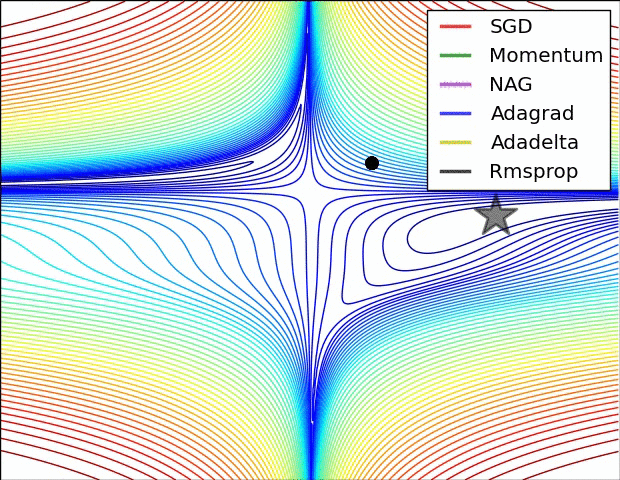收敛示意图</center></td>
    </tr>
</table>

经过上面的讨论，本项目中，将使用 __SGD和Adam__ 方法对模型进行优化。

3、__Dropout:__ 在模型训练过程中，由于模型参数数量庞大，并不是所有的参数都能得到差不多的训练机会，这就回导致一部分参数被过度训练，而一部分参数得不到训练，最后导致模型的过拟合。所以在模型中加入Dropout层，输入参数是一个(0,1)的概率，在训练过程中，模型会以输入的概率随机丢弃一部分参数，即将这部分权重置0，重点训练另一部分参数，如此重复不断的对绚练的参数进行调整，可以在一定程度上放置模型的过拟合。

### 步骤1:准备数据
项目中使用的Kaggle训练集的文件名是以 type.number.jpg 这样的方式命名的，比如 cat.0.jpg。但是项目中是使用 Keras 的 ImageDataGenerator 生成数据时，需要将不同种类的图片分在不同的文件夹中，因此需要对数据集进行分类处理。这里通过创建符号链接(symbol link)，来避免复制数据，占用不必要的空间。

In [20]:
import os
import shutil

train_cat = filter(lambda x:x[:3] == 'cat', cleaned_triandata)
train_dog = filter(lambda x:x[:3] == 'dog', cleaned_triandata)

def makedir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

makedir('data/train_img')
os.mkdir('data/train_img/cat')
os.mkdir('data/train_img/dog')

makedir('data/test_img')
shutil.copytree('data/test/', 'data/test_img/test')

cat_imgs, dog_imgs = 0, 0
for filename in train_cat:
    shutil.copy('data/train/'+filename, 'data/train_img/cat/'+filename)
    cat_imgs +=1

for filename in train_dog:
    shutil.copy('data/train/'+filename, 'data/train_img/dog/'+filename)
    dog_imgs +=1

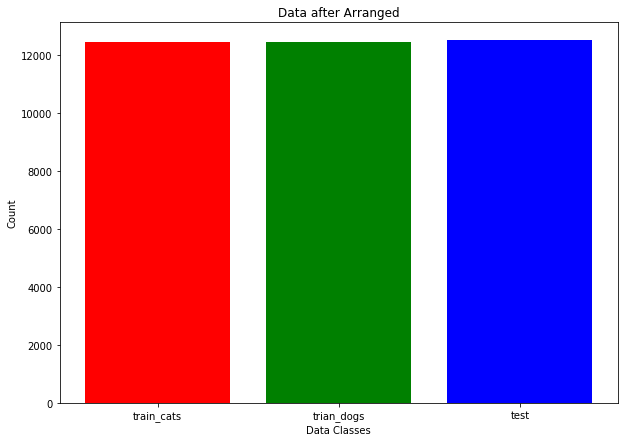

There are 12453 train cats, 12465 train dogs, and 12500 test images.


In [22]:
plt.figure(figsize=(10,7))
plt.title('Data after Arranged')
data = [cat_imgs, dog_imgs, len(test_files)]
plt.bar(range(len(data)), data, color='rgb',tick_label=['train_cats','trian_dogs','test']) 
plt.xlabel('Data Classes')
plt.ylabel('Count')
plt.show()
print('There are %d train cats, %d train dogs, and %d test images.' %(cat_imgs, dog_imgs, len(test_files)))

### 步骤2:提取特征向量
按照前面讨论中使用预训练模型的方法，在此步骤抽取处预训练模型的特征向量。

VGG19,ResNet50,Xception三个模型对输入数据都有要求，比如：VGG19和ResNet50的图像默认尺寸为$224\times224$,要求必须有3个通道，且图像最小宽、高不能小于32；Xception模型的图像默认尺寸为$299\times299$,要求必须有3个通道，且图像最小宽、高不能小于71，并且默认输入数值在 (-1, 1) 范围内。

当输入数值不符合默认要求时，使用每个模型的预处理函数 *preprocess_input* 即可将输入图片处理成该模型的标准输入。

当要输入与默认图片大小不同的图片时，只需传入当前图片大小即可，但是要保证输入的图片大小在允许的范围内。

一般的卷积神经网络在前面的若干层都是卷积池化层及其各种变种，后面几层是全连接层。全连接层之前的网络层被称为瓶颈层 (bottleneck). 将图片输入训练好的卷积神经网络直到瓶颈层的过程可以看做是对图像进行特征提取的过程。通常为了减少内存的消耗， 加快计算的过程，再将瓶颈层的结果输入全连接层之前，做一次全局平均池化，比如 ResNet50 瓶颈层输出结果是 $7\times7\times2048$，如果直接输入到全连接层，参数会非常多，所以进行一次全局平均池化，将输出矩阵调整为 $1\times1\times2048$，这种做法额外的好处是可以通过减少参数数量降低模型的过拟合程度。

在Keras中载入预训练模型，设置*include_top=False* 去掉顶层的分类层，设置*pooling='avg'* 指明使用全局池化层，在使用全局池化层后，VGG19输出的特征向量是$1\times512$，ResNet50和Xception输出的特征向量是$1\times2048$，将这三个向量拼接，最后得到$1\times4608$的特征向量。

In [23]:
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import *
import h5py

def extract_bottleneck(input_model, name,image_size, size=None,func = None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((width, height, 3))
    x = input_tensor
    if(func):
        x = Lambda(func)(x)
    
    base_model = input_model(input_tensor=x, weights='imagenet',include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    # image enhancement
    generator = ImageDataGenerator()
    train_gen = generator.flow_from_directory('data/train_img', image_size, shuffle=False,
                                             batch_size=size)
    test_gen = generator.flow_from_directory('data/test_img', image_size, shuffle=False,
                                            batch_size=size, class_mode=None)
    train_data = model.predict_generator(train_gen, train_gen.samples//train_gen.batch_size)
    test_data = model.predict_generator(test_gen, test_gen.samples//test_gen.batch_size)
    with h5py.File("./saved_models/bottleneck_%s.hdf5" % name) as h5:
        h5.create_dataset('train', data=train_data)
        h5.create_dataset('test', data=test_data)
        h5.create_dataset('label', data=train_gen.classes)
    

In [24]:
extract_bottleneck(vgg19.VGG19, 'VGG19', (224, 224), 16,vgg19.preprocess_input)
extract_bottleneck(resnet50.ResNet50, 'ResNet50', (224, 224), 16, resnet50.preprocess_input)
extract_bottleneck(xception.Xception, 'Xception', (299, 299), 16, xception.preprocess_input)

Found 24918 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:25: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 24918 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Found 24918 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 加载特征向量
经过上面的代码以后，将VGG19，ResNet50，Xception三个模型已经的特征向量分别保存到了三个对应的文件中，分别是：

bottleneck_VGG9.hdf5

bottleneck_ResNet50.hdf5

bottleneck_Xception.hdf5

这里需要载入这些特征向量，并且将它们合成一条特征向量.

In [25]:
from sklearn.utils import shuffle
np.random.seed(2019126)

X_train = []
X_test = []

for filename in ["./saved_models/bottleneck_VGG19.hdf5","./saved_models/bottleneck_ResNet50.hdf5", "./saved_models/bottleneck_Xception.hdf5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

print("Length of X_train is: %d" % X_train.shape[0])
print("Length of y_train is: %d" % y_train.shape[0])

if(X_train.shape[0] < y_train.shape[0]):
    X_train, y_train = shuffle(X_train, y_train[:X_train.shape[0]])
else:
    X_train, y_train = shuffle(X_train[:y_train.shape[0]], y_train)

Length of X_train is: 24912
Length of y_train is: 24918


### 构建模型
载入预处理的数据之后，先进行一次概率为 0.5 的 dropout，然后直接连接输出层，激活函数为 sigmoid，按之前的讨论，优化器首先使用默认参数的SGD，输出一个零维张量，表示某张图片中有狗的概率。

In [26]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

### 步骤4:绘制ACC和LOSS
实现一个类，保存模型的训练历史并绘制曲线图

In [27]:
from keras.callbacks import Callback

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type,size):
        iters = range(len(self.losses[loss_type]))
        #创建一个图
        plt.figure(figsize=size)
        plt.title('Losses Curve of Train and Valid')
        # train_loss
        plt.plot(iters, self.losses['epoch'], 'g', label='Train loss')
        # val_loss
        plt.plot(iters, self.val_loss['epoch'], 'k', label='Val loss')
        plt.grid(True)#设置网格形式
        plt.xlabel(loss_type)
        plt.ylabel('Losses')#给x，y轴加注释
        plt.legend(loc="upper right")#设置图例显示位置
        plt.show()

In [28]:
# 创建回调函数实例并训练模型
loss_history = LossHistory()

### 训练模型
模型构建完毕之后，可以开始训练。这里设置模型验证集大小为整个训练集的20%，并将整个训练过程中，val-loss最优的模型权重保存为.hdf5文件，方便在后面预测测试集时使用。

In [29]:
# 训练模型
from keras.callbacks import ModelCheckpoint  
def train_model(model,train_x,train_y, history,filename,epochs = 10, batch=128, verbose=1):
    my_checkpointer = ModelCheckpoint(filepath=filename, 
                                      verbose=1, save_best_only=True)

    model.fit(train_x, train_y, 
            validation_split=0.2,
            epochs=epochs, batch_size=batch, callbacks=[my_checkpointer,history], verbose=verbose)

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|SGD|default|default|/|/|0.0303|0.9896|0.0251|0.9928|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 43us/step - loss: 0.2200 - accuracy: 0.9561 - val_loss: 0.0394 - val_accuracy: 0.9880

Epoch 00001: val_loss improved from inf to 0.03937, saving model to ./saved_models/sgd_default.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 35us/step - loss: 0.0663 - accuracy: 0.9780 - val_loss: 0.0334 - val_accuracy: 0.9904

Epoch 00002: val_loss improved from 0.03937 to 0.03345, saving model to ./saved_models/sgd_default.hdf5
Epoch 3/10
19929/19929 [==============================] - 1s 36us/step - loss: 0.0512 - accuracy: 0.9823 - val_loss: 0.0285 - val_accuracy: 0.9910

Epoch 00003: val_loss improved from 0.03345 to 0.02847, saving model to ./saved_models/sgd_default.hdf5
Epoch 4/10
19929/19929 [==============================] - 1s 36us/step - loss: 0.0458 - accuracy: 0.9829 - val_loss: 0.0288 - val_accuracy: 0.9916

Epoch 00004: val_loss did not improve from 0.02847


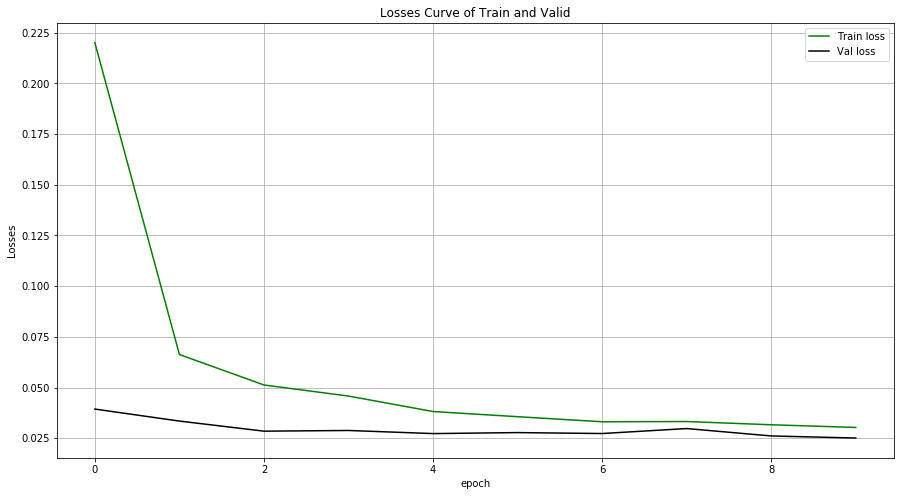

In [30]:
from keras import optimizers

sgd = optimizers.SGD()
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/sgd_default.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|SGD|default|default|/|/|0.0303|0.9896|0.0251|0.9928|
|SGD_opt1|0.02|default|/|/|0.0247|0.9911|0.0206|0.9940|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 41us/step - loss: 0.0371 - accuracy: 0.9873 - val_loss: 0.0254 - val_accuracy: 0.9924

Epoch 00001: val_loss improved from inf to 0.02537, saving model to ./saved_models/sgd_opt1.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 36us/step - loss: 0.0296 - accuracy: 0.9897 - val_loss: 0.0270 - val_accuracy: 0.9916

Epoch 00002: val_loss did not improve from 0.02537
Epoch 3/10
19929/19929 [==============================] - 1s 35us/step - loss: 0.0349 - accuracy: 0.9874 - val_loss: 0.0247 - val_accuracy: 0.9926

Epoch 00003: val_loss improved from 0.02537 to 0.02472, saving model to ./saved_models/sgd_opt1.hdf5
Epoch 4/10
19929/19929 [==============================] - 1s 35us/step - loss: 0.0276 - accuracy: 0.9895 - val_loss: 0.0238 - val_accuracy: 0.9924

Epoch 00004: val_loss improved from 0.02472 to 0.02380, saving model to ./saved_models/sgd_opt1.hdf5
Epoch 5/1

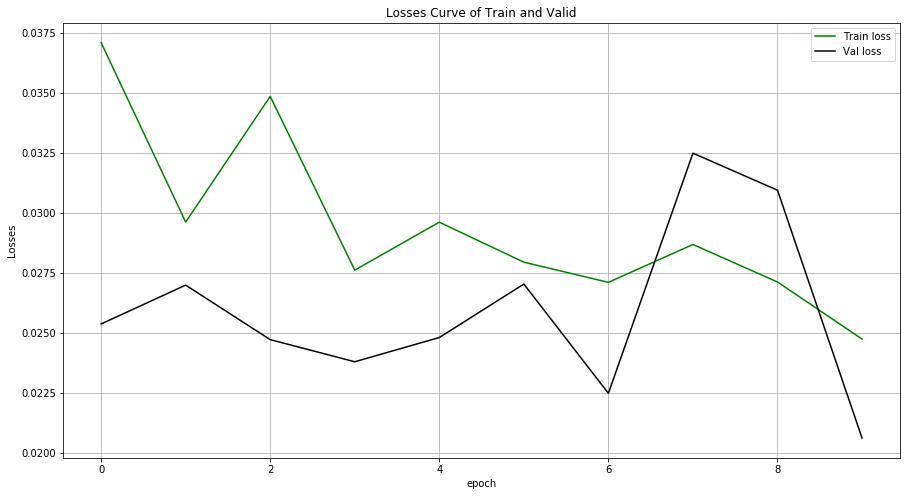

In [32]:
learning_rate = 0.02
sgd_opt1 = optimizers.SGD(lr=learning_rate)

model.compile(optimizer=sgd_opt1,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/sgd_opt1.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|SGD|default|default|/|/|0.0303|0.9896|0.0251|0.9928|
|SGD_opt1|0.02|default|/|/|0.0247|0.9911|0.0206|0.9940|
|SGD_opt1|0.02|$10^{-7}$|/|/|0.0216|0.9928|0.0194|0.9948|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 42us/step - loss: 0.0244 - accuracy: 0.9924 - val_loss: 0.0216 - val_accuracy: 0.9940

Epoch 00001: val_loss improved from inf to 0.02163, saving model to ./saved_models/sgd_opt2.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 36us/step - loss: 0.0244 - accuracy: 0.9912 - val_loss: 0.0363 - val_accuracy: 0.9886

Epoch 00002: val_loss did not improve from 0.02163
Epoch 3/10
19929/19929 [==============================] - 1s 36us/step - loss: 0.0247 - accuracy: 0.9910 - val_loss: 0.0220 - val_accuracy: 0.9936

Epoch 00003: val_loss did not improve from 0.02163
Epoch 4/10
19929/19929 [==============================] - 1s 36us/step - loss: 0.0216 - accuracy: 0.9928 - val_loss: 0.0194 - val_accuracy: 0.9948

Epoch 00004: val_loss improved from 0.02163 to 0.01945, saving model to ./saved_models/sgd_opt2.hdf5
Epoch 5/10
19929/19929 [==============================] - 1

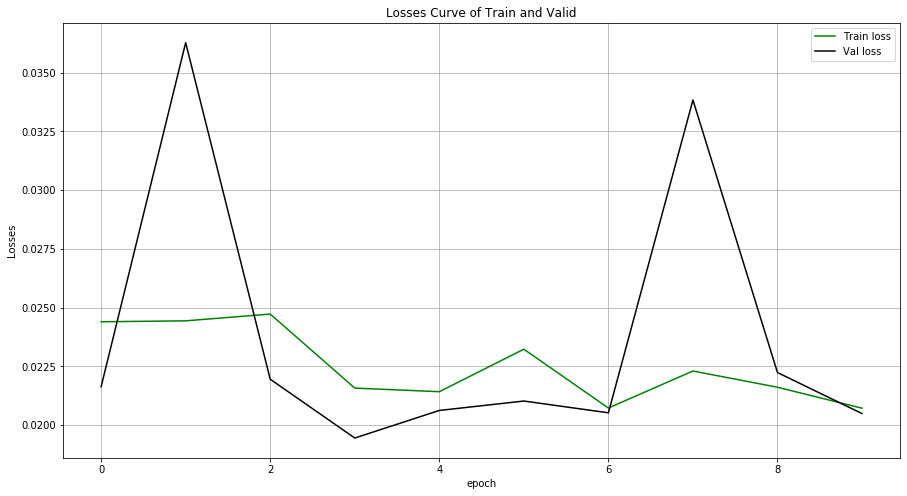

In [34]:
learning_rate = 0.02
decay_rate = 1e-7
sgd_opt2 = optimizers.SGD(lr=learning_rate, decay=decay_rate)

model.compile(optimizer=sgd_opt2,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/sgd_opt2.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 44us/step - loss: 0.0212 - accuracy: 0.9928 - val_loss: 0.0192 - val_accuracy: 0.9942

Epoch 00001: val_loss improved from inf to 0.01917, saving model to ./saved_models/adam_default.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0173 - accuracy: 0.9935 - val_loss: 0.0170 - val_accuracy: 0.9954

Epoch 00002: val_loss improved from 0.01917 to 0.01702, saving model to ./saved_models/adam_default.hdf5
Epoch 3/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0143 - accuracy: 0.9953 - val_loss: 0.0177 - val_accuracy: 0.9954

Epoch 00003: val_loss did not improve from 0.01702
Epoch 4/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0154 - accuracy: 0.9945 - val_loss: 0.0173 - val_accuracy: 0.9956

Epoch 00004: val_loss did not improve from 0.01702
Epoch 5/10
19929/19929 [===========================

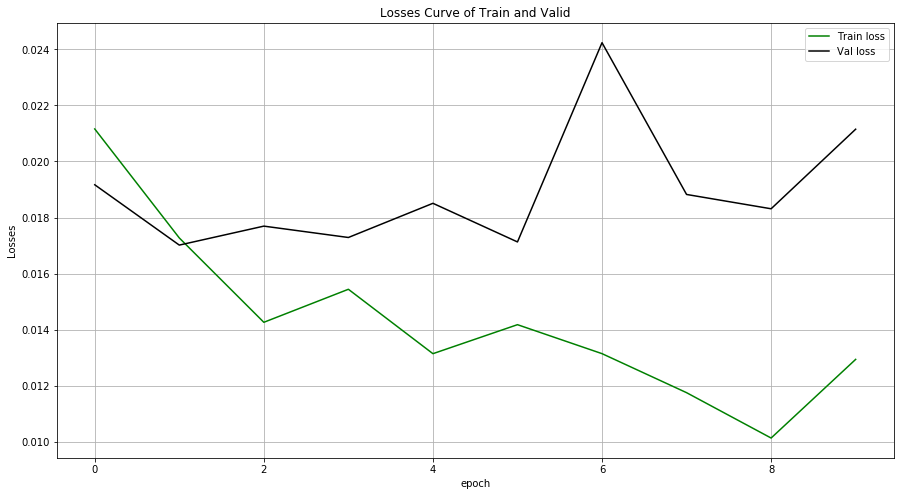

In [35]:
adam = optimizers.Adam()

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/adam_default.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|
|Adam_opt1|0.002|default|default|default|0.0167|0.9947|0.0183|0.9958|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 44us/step - loss: 0.0167 - accuracy: 0.9947 - val_loss: 0.0183 - val_accuracy: 0.9958

Epoch 00001: val_loss improved from inf to 0.01833, saving model to ./saved_models/adam_opt1.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.0205 - val_accuracy: 0.9960

Epoch 00002: val_loss did not improve from 0.01833
Epoch 3/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0204 - accuracy: 0.9950 - val_loss: 0.0243 - val_accuracy: 0.9946

Epoch 00003: val_loss did not improve from 0.01833
Epoch 4/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0256 - val_accuracy: 0.9944

Epoch 00004: val_loss did not improve from 0.01833
Epoch 5/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0126 - accuracy: 0.9957 - v

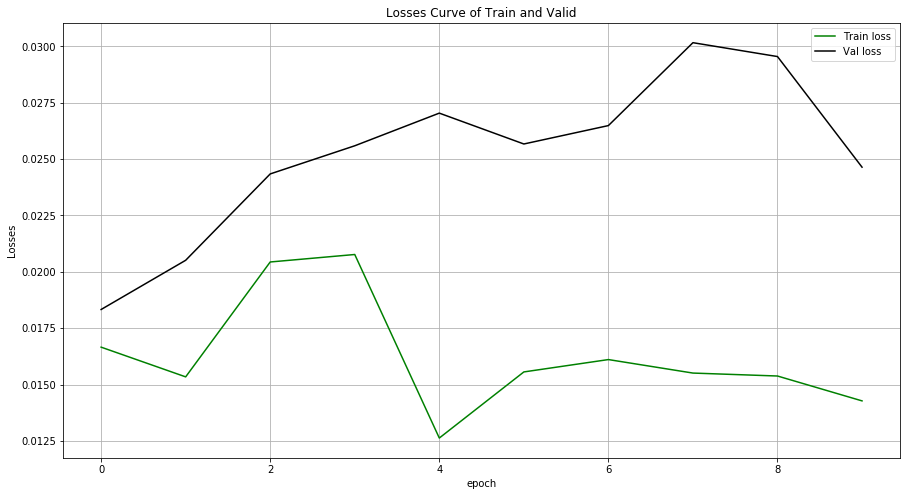

In [36]:
learning_rate = 0.002
adam_opt1 = optimizers.Adam(lr=learning_rate)

model.compile(optimizer=adam_opt1,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/adam_opt1.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|
|Adam_opt1|0.002|default|default|default|0.0167|0.9947|0.0183|0.9958|
|Adam_opt2|0.002|default|0.92|default|0.0176|0.9952|0.0291|0.9948|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 44us/step - loss: 0.0176 - accuracy: 0.9952 - val_loss: 0.0291 - val_accuracy: 0.9948

Epoch 00001: val_loss improved from inf to 0.02909, saving model to ./saved_models/adam_opt2.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0165 - accuracy: 0.9957 - val_loss: 0.0334 - val_accuracy: 0.9942

Epoch 00002: val_loss did not improve from 0.02909
Epoch 3/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0137 - accuracy: 0.9967 - val_loss: 0.0268 - val_accuracy: 0.9958

Epoch 00003: val_loss improved from 0.02909 to 0.02677, saving model to ./saved_models/adam_opt2.hdf5
Epoch 4/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.0291 - val_accuracy: 0.9962

Epoch 00004: val_loss did not improve from 0.02677
Epoch 5/10
19929/19929 [==============================] -

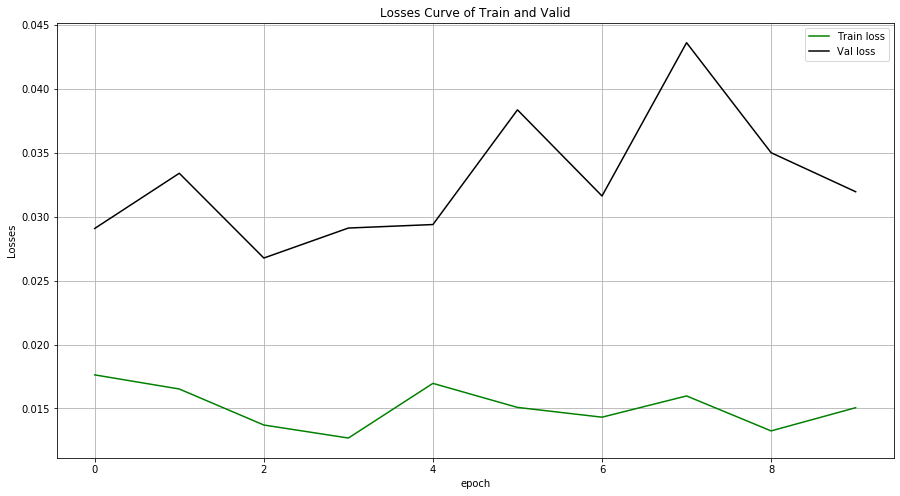

In [38]:
learning_rate = 0.002
beta_1 = 0.92
adam_opt2 = optimizers.Adam(lr=learning_rate, beta_1=beta_1)

model.compile(optimizer=adam_opt2,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/adam_opt2.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|
|Adam_opt1|0.002|default|default|default|0.0167|0.9947|0.0183|0.9958|
|Adam_opt2|0.002|default|0.92|default|0.0176|0.9952|0.0291|0.9948|
|Adam_opt3|0.002|default|0.92|0.995|0.0164|0.9961|0.0365|0.9952|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 44us/step - loss: 0.0173 - accuracy: 0.9957 - val_loss: 0.0382 - val_accuracy: 0.9946

Epoch 00001: val_loss improved from inf to 0.03816, saving model to ./saved_models/adam_opt3.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0137 - accuracy: 0.9968 - val_loss: 0.0428 - val_accuracy: 0.9954

Epoch 00002: val_loss did not improve from 0.03816
Epoch 3/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0146 - accuracy: 0.9961 - val_loss: 0.0386 - val_accuracy: 0.9946

Epoch 00003: val_loss did not improve from 0.03816
Epoch 4/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.0413 - val_accuracy: 0.9944

Epoch 00004: val_loss did not improve from 0.03816
Epoch 5/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0161 - accuracy: 0.9965 - v

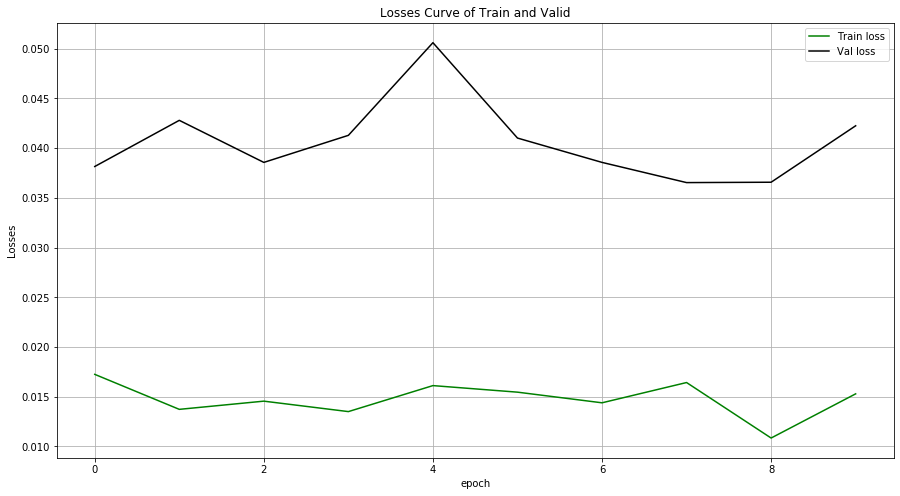

In [39]:
learning_rate = 0.002
beta_1 = 0.92
beta_2 = 0.995
adam_opt3 = optimizers.Adam(lr=learning_rate, beta_1=beta_1,beta_2=beta_2)

model.compile(optimizer=adam_opt3,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/adam_opt3.hdf5')
loss_history.loss_plot('epoch',(15,8))

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|
|Adam_opt1|0.002|default|default|default|0.0167|0.9947|0.0183|0.9958|
|Adam_opt2|0.002|default|0.92|default|0.0176|0.9952|0.0291|0.9948|
|Adam_opt3|0.002|default|0.92|0.995|0.0164|0.9961|0.0365|0.9952|
|Adam_opt4|0.002|$10^{-8}$|0.92|0.995|0.0091|0.9978|0.0362|0.9960|

Train on 19929 samples, validate on 4983 samples
Epoch 1/10
19929/19929 [==============================] - 1s 45us/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.0479 - val_accuracy: 0.9952

Epoch 00001: val_loss improved from inf to 0.04792, saving model to ./saved_models/adam_opt4.hdf5
Epoch 2/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.0402 - val_accuracy: 0.9952

Epoch 00002: val_loss improved from 0.04792 to 0.04021, saving model to ./saved_models/adam_opt4.hdf5
Epoch 3/10
19929/19929 [==============================] - 1s 37us/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.0380 - val_accuracy: 0.9956

Epoch 00003: val_loss improved from 0.04021 to 0.03801, saving model to ./saved_models/adam_opt4.hdf5
Epoch 4/10
19929/19929 [==============================] - 1s 38us/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.0368 - val_accuracy: 0.9962

Epoch 00004: val_loss improved from 0.03801 to 0.03685, s

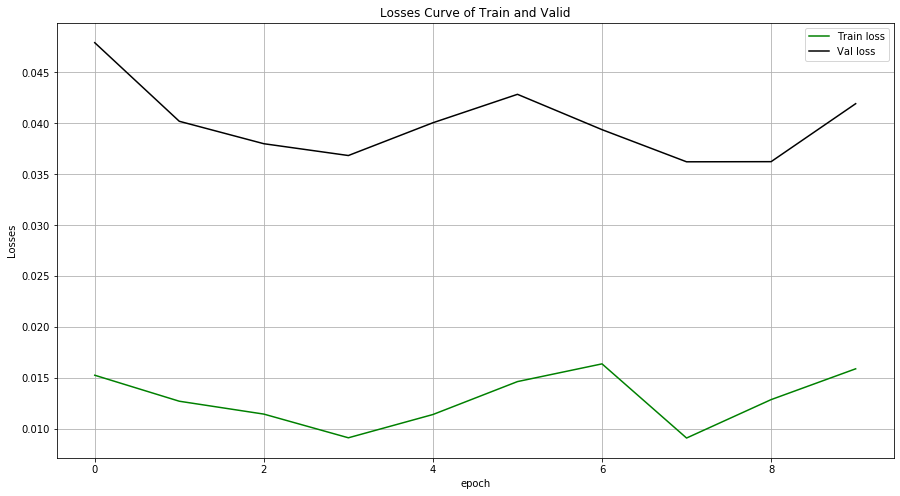

In [41]:
learning_rate = 0.002
beta_1 = 0.92
beta_2 = 0.995
decay = 1e-8
adam_opt4 = optimizers.Adam(lr=learning_rate, beta_1=beta_1,beta_2=beta_2,decay=decay)

model.compile(optimizer=adam_opt4,loss='binary_crossentropy',metrics=['accuracy'])
train_model(model, X_train, y_train[:X_train.shape[0]], loss_history,'./saved_models/adam_opt4.hdf5')
loss_history.loss_plot('epoch',(15,8))

最终得到如下结果：

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|SGD|default|default|/|/|0.0303|0.9896|0.0251|0.9928|
|SGD_opt1|0.02|default|/|/|0.0247|0.9911|0.0206|0.9940|
|SGD_opt1|0.02|$10^{-7}$|/|/|0.0216|0.9928|0.0194|0.9948|

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|
|Adam_opt1|0.002|default|default|default|0.0167|0.9947|0.0183|0.9958|
|Adam_opt2|0.002|default|0.92|default|0.0176|0.9952|0.0291|0.9948|
|Adam_opt3|0.002|default|0.92|0.995|0.0164|0.9961|0.0365|0.9952|
|Adam_opt4|0.002|$10^{-8}$|0.92|0.995|0.0091|0.9978|0.0362|0.9960|

In [44]:
import pandas as pd

model.load_weights('./saved_models/adam_default.hdf5')
print(X_test.shape)
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("data/test_img", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames[:X_test.shape[0]]):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_final.csv', index=None)
df.head(10)

(12496, 4608)
12496/12496 [==============================] - 1s 41us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005
5   6  0.005
6   7  0.005
7   8  0.005
8   9  0.005
9  10  0.005

# 结果

---

通过前面的项目完成过程，可以看出，从最开始的数据集探索，数据集清理，再到预训练模型的特征提取，然后是模型的构建以及模型的调优过程，最终得到模型的调优训练结果如下：

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|SGD|default|default|/|/|0.0303|0.9896|0.0251|0.9928|
|SGD_opt1|0.02|default|/|/|0.0247|0.9911|0.0206|0.9940|
|SGD_opt1|0.02|$10^{-7}$|/|/|0.0216|0.9928|0.0194|0.9948|

|params:|lr|decay|$\beta_{1}$|$\beta_{2}$|train loss|train acc|val loss|val acc|
|:----|:----:|:----:|:----:|:----|:----:|:----:|:----:|:----:|
|Adam|default|default|default|default|0.0173|0.9935|0.0170|0.9954|
|Adam_opt1|0.002|default|default|default|0.0167|0.9947|0.0183|0.9958|
|Adam_opt2|0.002|default|0.92|default|0.0176|0.9952|0.0291|0.9948|
|Adam_opt3|0.002|default|0.92|0.995|0.0164|0.9961|0.0365|0.9952|
|Adam_opt4|0.002|$10^{-8}$|0.92|0.995|0.0091|0.9978|0.0362|0.9960|

___

根据上面的结果和可视化图表，可以看出，不同的优化器对模型影响很大。在SGD调优时，可以看到SGD的train loss和val loss几乎是同步降低的，这说明模型性能得到了提升，并且保证了很好的泛化能力，模型没有过拟合，可以继续沿着当前思路进行模型优化。而在使用Adam优化器时，在参数调优时，模型的train loss和val loss是背离的，train loss在不断下降，而val loss却在上升，说明模型的泛化能力在降低，模型正在过拟合，需要改变参数调优思路。

___

最终，选择Adam优化器的默认值参数训练结果，对测试集进行分类，生成pred_final.csv文件，上传到kaggle进行评分，模型的最终得分为：
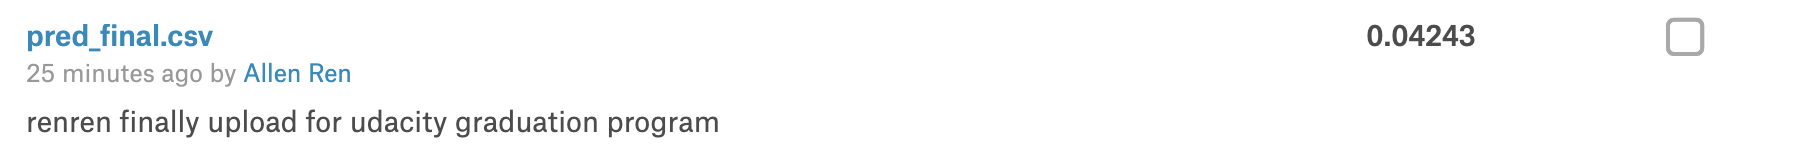


# 项目结论

## 对测试集的分类展示

以下是对测试集的分类展示，由于测试集数量庞大，并且时间有限，我并没有制作测试集的分类标签，这里只是对单张图片进行分类展示：

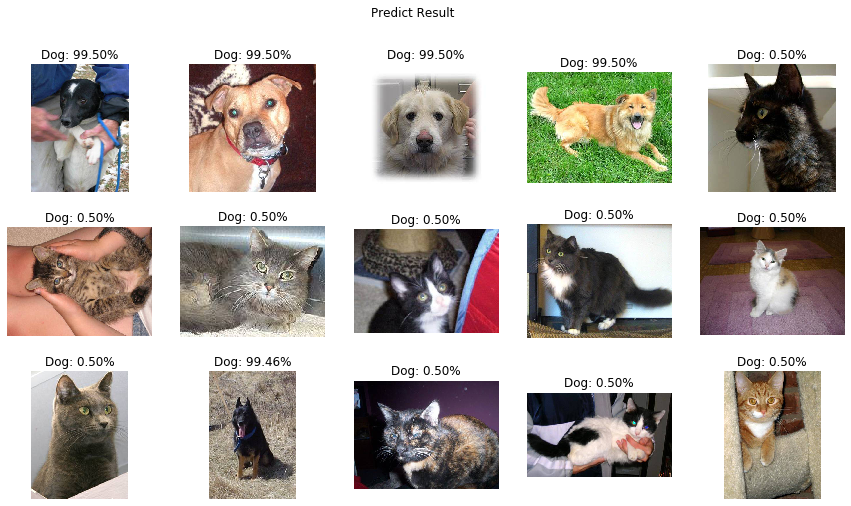

In [49]:
import math

df = pd.read_csv("pred_final.csv")
files = [str(df['id'][i])+'.jpg' for i in range(15)]
rates = np.array(df['label'][:15])

plt.figure(figsize=(15,8))
plt.suptitle('Predict Result')
classes = ['cat:','dog:']
for index, file in enumerate(files):
    plt.subplot(3,5,index+1)
    rate = math.modf(rates[index])
    name = 'Dog: {r:.2f}%'.format(r=100*rate[0])
    plt.title(name)
    plt.imshow(Image.open('data/test/'+file))
    plt.axis('off')
plt.show()

## 对项目的思考

猫狗分类问题在深度学习应用于计算机视觉领域时就已经是各类算法模型验证模型表现的典型问题。这在神经网络的应用中属于经典问题。首先猫、狗是生活中很常见的动物，很容易收集数据；其次，猫、狗有很多共同的特征，比如都是四肢行走动物，毛发相似度很高，都有尾巴，个头儿虽然有差异，但是个别品种的狗和猫相差不大等等。所以对猫、狗能否正确分类，就对算法模型提出的很高的挑战，毕竟从图像上看，人类本身也很容易犯错误。
    
深度学习无疑是处理图像问题的最佳机器学习模型，并且在CNN提出以后的各种图像处理赛事中，深度学习模型都取得了很好的成绩。但是相比于传统的机器学习模型，深度学习需要更多的数据，更强大的算力和资源。这也给深度学习的普及和推广设置了瓶颈。本项目是在AWS云平台上完成，主要步骤虽然也比较耗时，但是相对于个人笔记本电脑来说，性能还是相当强大的。

kaggle 上猫狗大战前几名的 loss 达到了 0.0330，相比于本文中的 0.04243，绝对值减少了 0.0943，说明模型算法还有很大的改进空间。本项目中只是简单的使用了 VGG19,Xception,和 ResNet50 这三个模型进行了提取特征向量，然后将特征向量直接拼接，忽略了模型的差异性和特征向量间的关系。而且VGG19所产生的512维度的特征向量相对于Inception_V3等模型少很多，这也是有待提高的地方。除了这三个模型，还可以增加更多新的模型，或者使用stacking的方法进行模型融合，进一步降低方差，提高分类的准确率。

另外可以将样本增强之后再使用，正如前面讨论中对图像增强方法——直方图均衡化的论述，图像对比度的增加肯定会对模型的表现有很大影响。

还可以在使用ImageDataGenerator数据生成器时，调整默认参数，给数据增加随机的偏移，旋转等，增加数据丰度。

   ---
   
## 需要改进的地方
回顾整个项目过程，需要改进的工作主要集中在以下几点：

1、数据预处理
数据预处理对模型的训练很关键，在本次项目中，对数据的预处理做的不足，也可能是导致模型准确率提高不明显的关键原因。对图片数据的预处理和数据集的预处理不同，对图片数据的预处理，主要是对图片施加随机的旋转，缩放等操作，从而丰富数据集，消除图片同质化。

2、模型训练
在模型训练方面，需要学习更多人的经验，对模型的训练进行调优，这主要包括模型的输入是否有最优区间，模型融合时不同模型之间的关系等。

3、模型调优
在模型调优工作中，主要集中在对优化器超参数的调优上，还可以从模型本身入手，对模型不同层级的输入输出进行调整。
